In [1]:
from fastai.vision.all import *
#hide
from fastbook import *

In [2]:
path = Path("../data/usq/train/images")

In [3]:
#fnames = get_image_files(path/"images")
fnames = get_image_files(path)

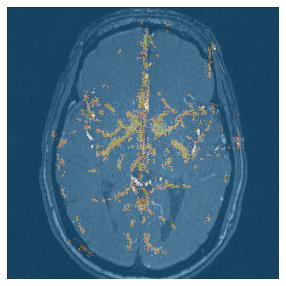

In [4]:
img = PILImage.create(fnames[0])
mask = PILMask.create(str(fnames[0]).replace('images','masks'))
#mask = PILMask.create(str(fnames[0]).replace('mipimages','mipmasks'))
ax = img.show()
ax = mask.show(ctx=ax)

In [5]:
np.histogram(np.array(mask))

(array([98019,   219,     0,     0,     0,     0,     2,   470,  3155,   535]),
 array([  0. ,  15.2,  30.4,  45.6,  60.8,  76. ,  91.2, 106.4, 121.6, 136.8, 152. ]))

In [12]:
msk = np.array(PILMask.create(str(fnames[0]).replace('images','masks')))
msk = (msk > 100)
msk = (msk * 1).astype(np.uint8)

In [13]:
np.histogram(np.array(msk))

(array([98238,     0,     0,     0,     0,     0,     0,     0,     0,  4162]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

### Load Data

In [2]:
from fastai.vision.all import *
#hide
from fastbook import *

In [3]:
#path = Path("../data/usq/train/images")
path = Path("../data/usq/imageprojections/all/images")
#path = Path("../data/usq/imageprojections/p4/images")

In [4]:
def get_msk(fname):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = str(fname).replace('images','masks')
    msk = np.array(PILMask.create(fn))
    msk = (msk > 100)
    msk = (msk * 1).astype(np.uint8)
    return PILMask.create(msk)

In [5]:
codes = ['Background', 'CV']

In [6]:
def get_y(o):
    return get_msk(o)

In [6]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize((640, 640), method=ResizeMethod.Pad, pad_mode = PadMode.Zeros),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [7]:
# dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
#                    get_items=get_image_files,
#                    splitter=RandomSplitter(),
#                    get_y=get_y,
#                    #item_tfms=Resize(224),
#                    item_tfms=Resize(560, method=ResizeMethod.Pad, pad_mode = PadMode.Zeros),
#                    batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [9]:
dsets = dblock.datasets(path)

In [8]:
dls = dblock.dataloaders(path, bs=1)
#dls = dblock.dataloaders(path, bs=8)
dls.vocab = codes

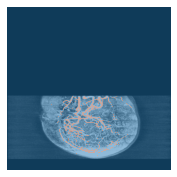

In [9]:
dls.show_batch()

In [10]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 81 items
2 datasets of sizes 65,16
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/usq/imageprojections/all/images/MNI_0663_3.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=320x247
  Pipeline: get_y -> PILBase.create
    starting from
      ../data/usq/imageprojections/all/images/MNI_0663_3.jpg
    applying get_y gives
      PILMask mode=L size=320x247
    applying PILBase.create gives
      PILMask mode=L size=320x247

Final sample: (PILImage mode=RGB size=320x247, PILMask mode=L size=320x247)


Found 81 items
2 datasets of sizes 65,16
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> Resize -- {'size': (640, 640), 'method': 'pad', 'pad_mode': 'zeros', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Set

In [11]:
# try progressive resizing
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y=get_y,
                   item_tfms=Resize((size), method=ResizeMethod.Pad, pad_mode = PadMode.Zeros),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])
            
    return dblock.dataloaders(path, bs=bs)

In [12]:
# try progressive resizing
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y=get_y,
                   item_tfms = Resize(256),
                   batch_tfms = [RandomResizedCrop(size), 
                                 *aug_transforms(mult=1.0, do_flip=True, 
                                                 max_rotate=30.0, max_zoom=1.5,
                                                  max_lighting=.8, max_warp=0.3, 
                                                 p_lighting=.9),
                                 Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [15]:
dls = get_dls(128, 128)
learn = Learner(dls, unet, CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, Dice()])
learn.fine_tune(4, cbs=[EarlyStoppingCallback(monitor='foreground_acc')])


epoch,train_loss,valid_loss,foreground_acc,dice,time
0,nan,0.260015,0.000000,0.000000,00:01


epoch,train_loss,valid_loss,foreground_acc,dice,time
0,nan,0.260015,0.000000,0.000000,00:01
1,nan,0.260015,0.000000,0.000000,00:01


No improvement since epoch 0: early stopping


In [ ]:
learn.fit_one_cycle(24, lr_max = 10e-4, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=3, min_lr=1e-8),
                                             EarlyStoppingCallback(monitor='foreground_acc', min_delta=0.01, patience=4),
                                             SaveModelCallback(monitor='foreground_acc', min_delta=0.01)])

## Modelling

### Dense U-Net

In [13]:
import sys
sys.path.append('/home/msadmin/notebooks/msc8001/src')
from dense_unet import *
from fastai import *

2021-11-28 06:46:01,210 util_log.py[147] INFO Start the program at:msdsvm, 10.0.0.4, with:Load module


Adjust wk folder for notebook failed


In [14]:
encoder = nn.Sequential(*list(models.densenet121().children())[0])
#unet = DynamicUnet(encoder, n_classes=2, img_size=(320, 320), blur=False, blur_final=False,
#                     self_attention=False, y_range=None, norm_type=NormType,
#                     last_cross=True,
#                     bottle=False)
unet = DynamicUnet(encoder, n_classes=2, img_size=(640, 640), blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False)
#print(unet(torch.rand(1,3,224,224)).shape)

    sn        layer     c    w    h                size
2    2         ReLU    64  320  320   (1, 64, 320, 320)
4    4  _DenseBlock   256  160  160  (1, 256, 160, 160)
6    6  _DenseBlock   512   80   80    (1, 512, 80, 80)
8    8  _DenseBlock  1024   40   40   (1, 1024, 40, 40)
11  11  BatchNorm2d  1024   20   20   (1, 1024, 20, 20)


In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Weighted Cross Entropy Loss Function

In [16]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [17]:
weights = torch.tensor([[0.5] + [1.5]]).cuda()
weights

tensor([[0.5000, 1.5000]], device='cuda:0')

In [18]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [19]:
# use customer weighted loss function
learn = Learner(dls, unet, loss_func=loss_func, metrics=[foreground_acc, Dice()])
#learn.summary()

In [44]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.543142,1.375201,1.000000,0.142393,00:04
1,0.911619,1.153336,1.000000,0.139541,00:04
2,0.775011,0.258891,0.601087,0.589469,00:04
3,0.626566,0.253248,0.965413,0.489012,00:04
4,0.534876,0.223134,0.946179,0.557447,00:04
5,0.466038,0.210359,0.915129,0.604059,00:04


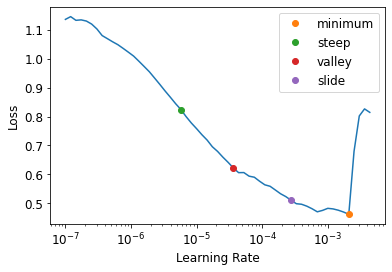

In [20]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [46]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(24, lr_max=slice(lrs.minimum, lrs.steep), 
                    cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=3, min_lr=1e-8),
                                             EarlyStoppingCallback(monitor='foreground_acc', min_delta=0.01, patience=4),
                                             SaveModelCallback(monitor='foreground_acc', min_delta=0.01)])

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.662754,0.432802,0.034824,0.064840,01:16
1,0.363215,0.201121,0.768705,0.520073,01:16
2,0.217638,0.148655,0.780160,0.633392,01:16
3,0.159536,0.127641,0.680673,0.661207,01:16
4,0.139101,0.123058,0.884432,0.633539,01:16
5,0.122768,0.109248,0.788476,0.686930,01:16
6,0.109621,0.105219,0.865672,0.686717,01:16
7,0.104846,0.105250,0.812280,0.692465,01:15
8,0.098279,0.110881,0.938734,0.654902,01:15
9,0.097106,0.100584,0.898913,0.688531,01:16


Better model found at epoch 0 with foreground_acc value: 0.03482411801815033.
Better model found at epoch 1 with foreground_acc value: 0.7687045931816101.
Better model found at epoch 2 with foreground_acc value: 0.7801604866981506.
Better model found at epoch 4 with foreground_acc value: 0.8844318389892578.
Epoch 4: reducing lr to 5.373144201198577e-07
Epoch 7: reducing lr to 5.583517305309977e-07
Better model found at epoch 8 with foreground_acc value: 0.938733696937561.
Better model found at epoch 11 with foreground_acc value: 0.9765737056732178.
Epoch 12: reducing lr to 3.868534887871106e-07
Epoch 15: reducing lr to 2.385222971408692e-07
No improvement since epoch 11: early stopping


In [49]:
learn.validate()

(#3) [0.18771697580814362,0.9653269052505493,0.6108503438489248]

In [25]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 7.59e-06, steepest point: 9.12e-07


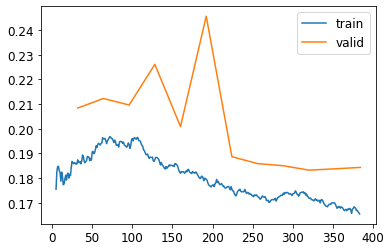

In [32]:
learn.recorder.plot_loss()

## Results

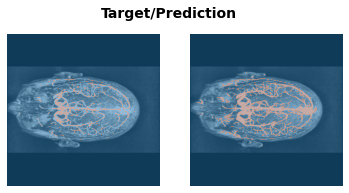

In [22]:
learn.show_results()

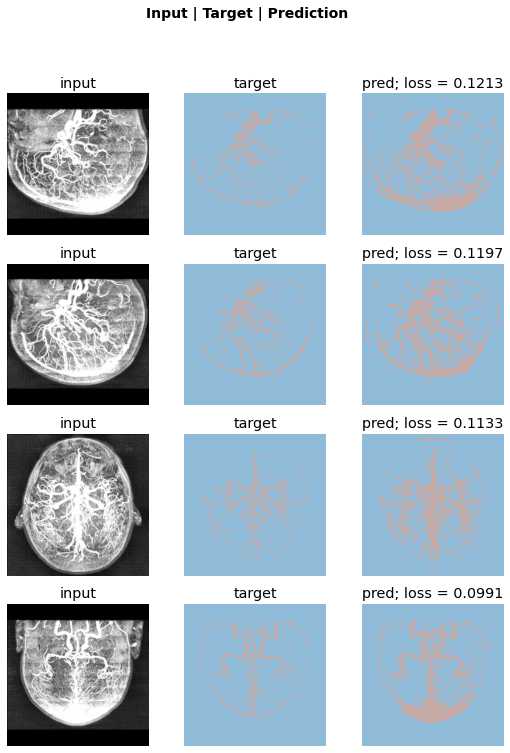

In [23]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=4)

### Save model

In [1]:
learn.export('dense_unet_mip_images_model.pkl')

NameError: name 'learn' is not defined

In [56]:
## Measure

In [57]:
fnames = get_image_files(path)
dl = learn.dls.test_dl(fnames[:5])

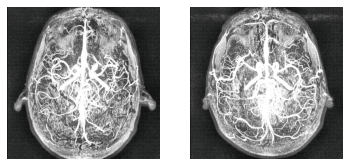

In [58]:
dl.show_batch()